In [78]:
import copy
import re
import snappy_manifolds
import snappy
from collections import OrderedDict, namedtuple
import sage.all
import sage.graphs.graph as graph
import networkx as nx
import matplotlib.pyplot as plt
"""
Links are made from Crossings.  The general model is that of
a PD diagram as described in

  http://katlas.org/wiki/Planar_Diagrams

See the file "doc.pdf" for the conventions, and the file
"test.py" for some examples of creating links.
"""
#from .. import graphs
#from .ordered_set import OrderedSet

#graphs
##################################################################################################
import networkx as nx


"""
Python implementation of graphs, reduced graphs, directed graphs, fat
graphs (graphs with ordered adjacency lists) and fat directed graphs.

Vertices are arbitrary hashable python objects. Graph methods must
not change vertices.

To instantiate a graph, provide a list of edges, as pairs of vertices,
and an optional list of additional vertices, which may be isolated.
Vertices are saved as a set, so redundancies in the vertex list will
be ignored.  Edges are saved as a list, so multiple edges are allowed.

If G is a graph and v a vertex of G then G[v] is a list of vertices
adjacent to v.  If there are n edges joining v to w then w will
appear in this list n times.  If G is a digraph, then G[v] returns
a list of all endpoints of edges having either head or tail at v.
There additional Digraph methods to get lists of incoming or outgoing
edges.

For most graphs G, G(v) returns the set of edges incident to G.
In the case of a FatGraph, the return value is the ordered list
of incident edges.  (Loops will appear twice).

When called as a function, an edge is the non-trivial involution of
its endpoints; calling it with one endpoint returns the other one.

One can iterate over edges as:

for x, y in G.edges:
  ...

where x and y will be the two endpoints of the edge (ordered as
tail, head in the case of directed edges).
"""
from collections import deque

try:
    import sage.all
    import sage.graphs.graph
    _within_sage = True
except ImportError:
    _within_sage = False

if not _within_sage:
    try:
        from .planarity import planar
        from spherogram.planarity import planar
    except ValueError:  # Allow importing from source directory
        pass


class CyclicList(list):
    def __getitem__(self, n):
        if isinstance(n, int):
            return list.__getitem__(self, n % len(self))
        elif isinstance(n, slice):
            # Python3 only: in python2, __getslice__ gets called instead.
            return list.__getitem__(self, n)

    def succ(self, x):
        return self[(self.index(x) + 1) % len(self)]

    def pred(self, x):
        return self[(self.index(x) - 1) % len(self)]


class BaseEdge(tuple):
    """
    Base class for edges: a 2-tuple of vertices with extra methods.
    Calling a BaseEdge with one of its vertices returns the other one.
    """

    def __new__(cls, x, y, **kwargs):
        return tuple.__new__(cls, (x, y))

    def __call__(self, end):
        """
        Calling an edge with one endpoint returns the other one.
        """
        if end is self[0]:
            return self[1]
        elif end is self[1]:
            return self[0]
        else:
            raise ValueError('Vertex is not an endpoint')

    def __hash__(self):
        return id(self)

    def incident_to(self):
        return list(self)

    def is_loop(self):
        return self[0] is self[1]


class Edge(BaseEdge):
    """
    An undirected edge.  We allow multiple Edges between the same
    vertices, so the __eq__ operator is overloaded.
    """

    def __repr__(self):
        return '%s --- %s' % self

    def __hash__(self):
        return id(self)

    def __eq__(self, other):
        return self is other


class MultiEdge(BaseEdge):
    """
    An undirected edge.  MultiEdges are equal if they have the
    same vertices.  The multiplicity is initialized to 1.
    """

    def __init__(self, x, y):
        self.multiplicity = 1

    def __repr__(self):
        return '%s --%d-- %s' % (self[0], self.multiplicity, self[1])

    def __hash__(self):
        return id(self)

    def __eq__(self, other):
        return set(self) == set(other)


class DirectedEdge(BaseEdge):
    """
    An Edge with a tail and a head.  The two vertices can be accessed as
    E.tail and E.head
    """

    def __repr__(self):
        return '%s --> %s' % self

    def __hash__(self):
        return id(self)

    def __eq__(self, other):
        return self is other

    @property
    def head(self):
        return self[1]

    @property
    def tail(self):
        return self[0]


class DirectedMultiEdge(DirectedEdge):
    """
    A DirectedEdge with multiplicity.  DirectedMultiEdges are equal if
    they have the same head and tail.  The multiplicity is initialized to 1.
    """

    def __init__(self, v, w):
        self.multiplicity = 1

    def __repr__(self):
        return '%s --%d-> %s' % (self[0], self.multiplicity, self[1])

    def __hash__(self):
        return id(self)

    def __eq__(self, other):
        return tuple(self) == tuple(other)


class FatEdge(Edge):
    """
    An Edge that knows its place among the edges incident to each
    of its vertices.  Initialize with two pairs (v,n) and (w,m) meaning
    that this edge joins v to w and has index n at v and m at w.
    The parity of the optional integer argument twists determines
    whether the edge is twisted or not.
    """
    def __new__(cls, x, y, twists=0):
        return tuple.__new__(cls, (x[0], y[0]))

    def __init__(self, x, y, twists=0):
        self.slots = [x[1], y[1]]
        self.twisted = bool(twists % 2)

    def __repr__(self):
        return '%s[%d] -%s- %s[%d]' % (self[0], self.slots[0],
                                       'x' if self.twisted else '-',
                                       self[1], self.slots[1])

    def __hash__(self):
        return id(self)

    def slot(self, vertex):
        try:
            return self.slots[self.index(vertex)]
        except ValueError:
            raise ValueError('Vertex is not an end of this edge.')

    def set_slot(self, vertex, n):
        try:
            self.slots[self.index(vertex)] = n
        except ValueError:
            raise ValueError('Vertex is not an end of this edge.')


class Graph():
    """
    A set of vertices and a set of edges joining pairs of vertices.
    Vertices are arbitrary hashable objects and should not be
    modified by Graph methods.
    """
    edge_class = Edge

    def __init__(self, pairs=[], singles=[]):
        self.vertices = set()
        self.edges = set()
        self.incidence_dict = {}
        self.Edge = self.__class__.edge_class
        for pair in pairs:
            self.add_edge(*pair)
        for vertex in singles:
            self.add_vertex(vertex)
        self._validate()

    def _validate(self):
        pass

    def __repr__(self):
        V = 'Vertices:\n  ' + '\n  '.join(str(v) for v in self.vertices)
        E = 'Edges:\n  ' + '\n  '.join(str(e) for e in self.edges)
        return '%s\n%s' % (V, E)

    def __call__(self, vertex):
        """
        Return a list of incident edges, including loops, which appear
        twice.
        """
        return self.incidence_dict[vertex]

    def __getitem__(self, vertex):
        """
        Return a list of adjacent vertices, one per incident edge.
        """
        return [e(vertex) for e in self.incidence_dict[vertex]]

    def incident(self, vertex):
        """
        Return the set of non-loops incident to the vertex.
        """
        return set(e for e in self.incidence_dict[vertex] if not e.is_loop())

    def edges_between(self, vertex1, vertex2):
        return self.incident(vertex1).intersection(self.incident(vertex2))

    # Allow flows to go in either direction across an edge.
    flow_incident = incident

    def children(self, vertex):
        """
        Return the set of distinct adjacent vertices.
        """
        return set(e(vertex) for e in self.incidence_dict[vertex])

    def add_edge(self, *args, **kwargs):
        edge = self.Edge(*args, **kwargs)
        self.edges.add(edge)
        self.vertices.update(edge)
        for v in edge:
            try:
                self.incidence_dict[v].append(edge)
            except KeyError:
                self.incidence_dict[v] = [edge]
        return edge

    def remove_edge(self, edge):
        for vertex in edge:
            try:
                self.incidence_dict[vertex].remove(edge)
            except (KeyError, ValueError):
                pass
        self.edges.remove(edge)

    def add_vertex(self, hashable):
        self.vertices.add(hashable)
        if hashable not in self.incidence_dict:
            self.incidence_dict[hashable] = []

    def remove_vertex(self, hashable):
        incident = list(self.incidence_dict[hashable])
        for edge in incident:
            self.remove_edge(edge)
        self.vertices.remove(hashable)
        self.incidence_dict.pop(hashable)

    def valence(self, vertex):
        """
        Return the valence of a vertex.
        """
        return len(self.incidence_dict[vertex])

    def depth_first_search(self, start):
        """
        Generator which yields the vertices in the same component as
        start, in depth-first order beginning with start.
        """
        if start not in self.vertices:
            raise ValueError('That starting vertex is not in the graph.')
        stack = [start]
        seen = set(stack)
        while stack:
            current = stack.pop()
            for v in self.children(current):
                if v not in seen:
                    stack.append(v)
                    seen.add(v)
            yield current

    def breadth_first_edges(self, source, forbidden=set(), for_flow=False):
        """
        Generator for non-loop edges of a graph in the complement of
        a forbidden set, ordered by distance from the source.  Used for
        generating paths in the Ford-Fulkerson method.

        Yields triples (e, v, f) where e and f are edges containing v
        and e precedes f in the breadth-first ordering.

        The optional flag "for_flow" specifies that the flow_incident
        method should be used in place of the incident method for
        extending paths.  For example, Digraphs set flow_incident =
        outgoing.
        """
        incident = self.flow_incident if for_flow else self.incident
        initial = incident(source) - forbidden
        seen = forbidden | initial
        # Use a deque since we need to popleft.
        fifo = deque([(None, source, e) for e in initial])
        while fifo:
            parent, vertex, child = fifo.popleft()
            new_edges = incident(child(vertex)) - seen
            seen |= new_edges
            fifo.extend([(child, child(vertex), edge) for edge in new_edges])
            yield parent, vertex, child

    def next(self):  # For Python 2 compatibility
        return self.__next__()

    def components(self, deleted_vertices=[]):
        """
        Return the vertex sets of the connected components of the
        graph obtained by removing the deleted_vertices and any edges
        incident to them.

        >>> G = Graph([(0,1),(1,2),(2,0),(2,3),(3,4),(4,2)])
        >>> G.components() == [frozenset([0, 1, 2, 3, 4])]
        True
        >>> sorted(G.components(deleted_vertices=[2])) == [frozenset([0, 1]), frozenset([3, 4])]
        True
        >>> G.components(deleted_vertices=[0]) == [frozenset([1, 2, 3, 4])]
        True
        """
        forbidden = set()
        for vertex in deleted_vertices:
            forbidden |= self.incident(vertex)
        vertices, result = self.vertices - set(deleted_vertices), []
        while vertices:
            component, start = set(), vertices.pop()
            component.add(start)
            generator = self.breadth_first_edges(
                source=start, forbidden=forbidden)
            for parent, vertex, child in generator:
                new_vertex = child(vertex)
                component.add(new_vertex)
                if new_vertex in vertices:
                    vertices.remove(new_vertex)
            result.append(frozenset(component))
        return result

    def is_connected(self, deleted_vertices=[]):
        """
        Determine whether the graph obtained by removing the
        deleted_vertices and incident edges is connected.

        >>> G = Graph([(0,1),(1,2),(2,0),(2,3),(3,4),(4,2)])
        >>> G.is_connected(deleted_vertices=[2])
        False
        """
        return len(self.components(deleted_vertices)) <= 1

    def one_min_cut(self, source, sink, capacity=None):
        """
        Find one minimal cut which separates source from sink, using
        the classical Ford-Fulkerson algorithm.

        Returns a dict containing the set of vertices on the source
        side of the cut, the set of edges that cross the cut, a
        maximal family of weighted edge-disjoint paths from source to
        sink, the set of edges with non-zero residual, and the
        associated maximum flow.

        The edge capacities are supplied as a dictionary, with
        edges as keys and the capacity of the edge as value.  If
        no capacity dict is supplied, every edge is given capacity
        1.  Edges omitted from the capacity dict have infinite
        capacity.

        When called as a Graph method, the flow is relative to the
        implicit orientation of an undirected edge e from e[0] to
        e[1].  (This is determined when the edge is first constructed
        from a pair of vertices.) A negative flow value means the flow
        direction is from e[1] to e[0].  When called as a DiGraph
        method, paths are directed and flows go in the direction of
        the directed edge.

        >>> caps = {('s',0):3,('s',1):2,(0,1):2,(0,'t'):4,(1,'t'):1}
        >>> G = Graph(caps.keys())
        >>> cap_dict = dict((e, caps[tuple(e)]) for e in G.edges)
        >>> flow = G.one_min_cut('s', 't', cap_dict)['flow']
        >>> [flow[e] for e in sorted(G.edges, key=str)]
        [-1, 4, 1, 3, 2]
        >>> G = Digraph(caps.keys())
        >>> cap_dict = dict((e, caps[tuple(e)]) for e in G.edges)
        >>> flow = G.one_min_cut('s', 't', cap_dict)['flow']
        >>> [flow[e] for e in sorted(G.edges, key=str)]
        [0, 3, 1, 3, 1]
        """
        if sink == source:
            return None
        if capacity is None:
            residual = dict.fromkeys(self.edges, 1)
        else:
            residual = dict.copy(capacity)
            for e in self.edges:
                if e not in residual:
                    residual[e] = float('inf')
        full_edges = set(e for e in self.edges if residual[e] == 0)
        children = {}
        for vertex in self.vertices:
            children[vertex] = set()
        cut_set = set()
        path_list = []
        while True:
            # Try to find a new path from source to sink
            parents, cut_set, reached_sink = {}, set([source]), False
            generator = self.breadth_first_edges(
                source=source,
                forbidden=full_edges,
                for_flow=True)
            for parent, vertex, child in generator:
                parents[child] = (parent, vertex)
                cut_set.add(child(vertex))
                if child(vertex) == sink:
                    reached_sink = True
                    break
            # If we did not get to the sink, we visited every vertex
            # reachable from the source, thereby providing the cut
            # set.
            if not reached_sink:
                break
            # If we got to the sink, do the bookkeeping and continue.
            path = deque()
            flow = residual[child]
            while True:
                path.appendleft((vertex, child))
                children[vertex].add(child)
                if vertex == source:
                    break
                child = parent
                parent, vertex = parents[child]
                flow = min(flow, residual[child])
            for vertex, edge in path:
                residual[edge] -= flow
                if residual[edge] == 0:
                    full_edges.add(edge)
            path_list.append((flow, path))
        # Find the cut edges.
        cut_edges = set()
        for vertex in cut_set:
            cut_edges |= set(edge for edge in self.edges
                             if vertex in edge
                             and edge(vertex) not in cut_set)
        # Find the unsaturated edges.
        unsaturated = [e for e in self.edges if residual[e] > 0]
        flow_dict = dict.fromkeys(self.edges, 0)
        # Compute the flow.
        for flow, edges in path_list:
            for vertex, edge in edges:
                if vertex == edge[0]:
                    flow_dict[edge] += flow
                else:
                    flow_dict[edge] -= flow
        return {'set': cut_set, 'edges': cut_edges, 'paths': path_list,
                'residuals': residual, 'unsaturated': unsaturated,
                'flow': flow_dict}

    def reduced(self):
        R = ReducedGraph()
        for e in self.edges:
            R.add_edge(*e)
        return R

    def is_planar(self):
        return self.reduced().is_planar()

    def merge(self, V1, V2):
        """
        Merge two vertices and remove all edges between them.  The
        vertices must support the __or__ method (e.g. all vertices
        might be frozensets).  The two vertices V1 and V2 are replaced
        by V1|V2.

        >>> G = Graph([(0,1),(1,2),(2,0)]).mergeable()
        >>> F = lambda x: frozenset([x])
        >>> G.merge(F(1),F(2))
        >>> set(G.vertices) == {frozenset([1, 2]), frozenset([0])}
        True
        """
        new_vertex = V1 | V2
        if new_vertex in self.vertices:
            raise ValueError('Merged vertex already exists!')
        self.edges -= set(e for e in self.edges if V1 in e and V2 in e)
        self.vertices.remove(V1)
        self.vertices.remove(V2)
        old_vertices = (V1, V2)
        self.vertices.add(new_vertex)
        for edge in [e for e in self.edges if V1 in e or V2 in e]:
            self.edges.remove(edge)
            x, y = edge
            if x in old_vertices:
                self.edges.add(self.Edge(new_vertex, y))
            if y in old_vertices:
                self.edges.add(self.Edge(x, new_vertex))

    def mergeable(self):
        """
        Return a new graph whose vertices are singleton frozensets,
        each containing a vertex of this graph, and with edges
        corresponding to those of this graph.  The new graph
        will support merging vertices.
        """
        V = [frozenset([v]) for v in self.vertices]
        E = [self.Edge(frozenset([x]), frozenset([y])) for x, y in self.edges]
        return self.__class__(E, V)

    def to_networkx(self):
        """
        Return a copy of the graph in the networkx format
        """
        G = nx.Graph()
        G.add_nodes_from(self.vertices)
        G.add_edges_from(self.edges)
        return G


class ReducedGraph(Graph):
    """
    A graph with at most one edge between any two vertices,
    but having edges with multiplicities.
    """
    edge_class = MultiEdge

    def __init__(self, pairs=[], singles=[]):
        self.Edge = self.__class__.edge_class
        self.find_edge = dict()
        Graph.__init__(self, pairs, singles)

    def add_edge(self, x, y):
        if (x, y) in self.find_edge:
            edge = self.find_edge[(x, y)]
            edge.multiplicity += 1
        else:
            edge = self.Edge(x, y)
            self.vertices.update([x, y])
            self.edges.add(edge)
            self.find_edge[(x, y)] = edge
            for v in edge:
                try:
                    self.incidence_dict[v].append(edge)
                except KeyError:
                    self.incidence_dict[v] = [edge]
        return edge

    def multi_valence(self, vertex):
        """
        Return the valence of a vertex, counting edge multiplicities.
        """
        return sum(e.multiplicity for e in self.incidence_dict[vertex])

    def is_planar(self):
        """
        Return the planarity.
        """
        verts_with_loops = set()
        non_loop_edges = set()
        for e in self.edges:
            v, w = e
            if v != w:
                non_loop_edges.add((v, w))
            else:
                verts_with_loops.add(v)

        sans_loops = ReducedGraph(non_loop_edges)
        if _within_sage:
            S = sans_loops.sage(loops=False, multiedges=False)
            is_planar = S.is_planar(set_embedding=True)
            embedding = S.get_embedding() if is_planar else None
        else:
            is_planar, embedding = planar(sans_loops)

        if is_planar:
            for v in verts_with_loops:
                embedding[v].append(v)
            self._embedding = embedding

        return is_planar

    def embedding(self):
        if self.is_planar():
            return self._embedding

    def one_min_cut(self, source, sink):
        capacity = {e: e.multiplicity for e in self.edges}
        cut = Graph.one_min_cut(self, source, sink, capacity)
        cut['size'] = sum(e.multiplicity for e in cut['edges'])
        return cut

    def cut_pairs(self):
        """
        Return a list of cut_pairs.  The graph is assumed to be
        connected and to have no cut vertices.
        """
        pairs = []
        majors = [v for v in self.vertices if self.valence(v) > 2]
        if len(majors) == 2:
            v, V = majors
            if self.valence(v) == 3:
                return []
            edge = self.find_edge[(v, V)]
            if not edge or edge.multiplicity < 2:
                return []
            return majors
        major_set = set(majors)
        for n in range(1, len(majors)):
            for v in majors[:n]:
                pair = (v, majors[n])
                components = self.components(deleted_vertices=pair)
                if len(components) > 2:
                    pairs.append(pair)
                elif len(components) == 2:
                    M0 = len(major_set & components[0])
                    M1 = len(major_set & components[1])
                    edge = self.find_edge[pair]
                    if edge:
                        if M0 or M1:
                            pairs.append(pair)
                            continue
                    else:
                        if M0 and M1:
                            pairs.append(pair)
        return pairs


class FatGraph(Graph):
    """
    A FatGraph is a Graph which maintains a CyclicList of incident
    edges for each vertex.  The edges are FatEdges, which come in two
    flavors: twisted and untwisted.  Since the incident edges are in
    particular cyclically ordered, a FatGraph has a canonical
    embedding as a spine of a surface with boundary.  However, a
    CyclicList has a first element.  This extra data, namely a choice
    of distinguished edge for each vertex, is used to give a canonical
    mapping from FatGraphs to link or tangle diagrams.

    A FatGraph should be initialized with a sequence of either double
    pairs ((v,n), (w,m)) or triples ((v,n), (w,m), T).  These indicate
    that there is an edge from v to w which has index n at v and m at
    w.  If T is supplied then the parity of T determines the twist.
    """
    edge_class = FatEdge

    def __call__(self, vertex):
        return self.incidence_dict[vertex]

    def add_edge(self, *args):
        incidences = self.incidence_dict
        edge = self.Edge(*args)
        self.edges.add(edge)
        self.vertices.update(edge)
        for v in edge:
            # the values of incidence_dict should be objects that keep
            # themselves sorted.
            if v in incidences:
                incidences[v].append(edge)
                incidences[v].sort(key=lambda e: e.slot(v))
            else:
                incidences[v] = CyclicList([edge])
        return edge

    def _validate(self):
        for v in self.vertices:
            slots = [e.slot(v) for e in self(v)]
            assert slots == range(len(slots))

    def reorder(self, vertex, cyclist):
        for e, n in zip(self(vertex), cyclist):
            e.set_slot(vertex, n)
        self.incidence_dict[vertex].sort(key=lambda e: e.slot(vertex))

    def boundary_cycles(self):
        left = [(e[0], e, 'L') for e in self.edges]
        right = [(e[0], e, 'R') for e in self.edges]
        sides = left + right
        cycles = []
        while sides:
            cycle = []
            v, e, s = start = sides.pop()
            while True:
                cycle.append(e)
                # cross the edge
                v = e(v)
                if ((e.twisted and s == 'L') or
                        (not e.twisted and (s == 'L') == (v == e[0]))):
                    # go counter-clockwise
                    e = self(v).succ(e)
                    s = 'R' if e.twisted or v == e[0] else 'L'
                else:  # go clockwise
                    e = self(v).pred(e)
                    s = 'L' if e.twisted or v == e[0] else 'R'
                if (e[0], e, s) == start:
                    cycles.append(cycle)
                    break
                sides.remove((e[0], e, s))
        return cycles

    def filled_euler(self):
        return len(self.vertices) - len(self.edges) + len(self.boundary_cycles())


class Digraph(Graph):
    """
    A directed graph.  This subclass adds methods for finding incoming
    and outgoing edges, indegree and outdegree, and deals with all
    three notions of connectedness for digraphs.

    >>> G = Digraph([(0,1),(1,2),(2,3),(3,1),(4,2)])
    >>> G.indegree(1), G.outdegree(1)
    (2, 1)
    >>> G.is_weakly_connected()
    True
    >>> G.is_connected()
    False
    >>> G.is_strongly_connected()
    False
    >>> G.components()
    Traceback (most recent call last):
        ...
    ValueError: Not meaningful for Digraphs.
    Use weak_components() or strong_components()
    >>> G.weak_components() == [frozenset([0, 1, 2, 3, 4])]
    True
    >>> G.strong_components() == [frozenset([1, 2, 3]), frozenset([0]), frozenset([4])]
    True
    """

    edge_class = DirectedEdge

    def outgoing(self, vertex):
        """
        Return the set of non-loop edges which *begin* at the vertex.
        """
        return set(e for e in self(vertex)
                   if e.tail is vertex and e.head is not vertex)

    # Force flows to go in the direction of the edge.
    flow_incident = outgoing

    def incoming(self, vertex):
        """
        Return the set of non-loop edges which *end* at the vertex.
        """
        return set(e for e in self(vertex)
                   if e.head is vertex and e.tail is not vertex)

    def children(self, vertex):
        """
        Return the set of distinct vertices which are endpoints of
        outgoing non-loop edges.
        """
        return set(e(vertex) for e in self.outgoing(vertex))

    def indegree(self, vertex):
        return len([e for e in self.incidence_dict[vertex] if e.head is vertex])

    def outdegree(self, vertex):
        return len([e for e in self.incidence_dict[vertex] if e.tail is vertex])

    # For Digraphs we call them weak components.
    weak_components = Graph.components

    def components(self):
        raise ValueError('Not meaningful for Digraphs.\n'
                         'Use weak_components() or strong_components()')

    def is_weakly_connected(self):
        """
        A digraph is weakly connected if the associated undirected graph
        is connected.
        """
        return len(self.weak_components()) <= 1

    def is_connected(self):
        """
        A digraph is connected if, for every pair of vertices v, w,
        there is either a directed path from v to w or a directed path
        from w to v.  This is equivalent to the condition that the
        strong component DAG be a linear order.  Note that
        reachability is not a symmetric relation, so there is no
        associated notion of a connected component.
        """
        DAG = self.component_DAG()
        if not DAG.is_weakly_connected():
            return False
        return all(DAG.indegree(v) <= 1 and DAG.outdegree(v) <= 1
                   for v in DAG.vertices)

    def strong_components(self):
        """
        Return the vertex sets of the strongly connected components.

        >>> G = Digraph([(0,1),(0,2),(1,2),(2,3),(3,1)])
        >>> G.strong_components() == [frozenset([1, 2, 3]), frozenset([0])]
        True
        >>> G = Digraph([(0,1),(0,2),(1,2),(2,3),(1,3)])
        >>> G.strong_components() == [frozenset([3]), frozenset([2]), frozenset([1]), frozenset([0])]
        True
        """
        return StrongConnector(self).components

    def is_strongly_connected(self):
        """
        A digraph is strongly connected if, for every pair of vertices
        v, w, there is a directed path from v to w and a directed path
        from w to v.
        """
        return len(self.strong_components()) <= 1

    def component_DAG(self):
        """
        Return the acyclic digraph whose vertices are the strong
        components of this digraph.  Two components are joined by an
        edge if this digraph has an edge from one component to the
        other.

        >>> G = Digraph([(0,1),(0,2),(1,2),(2,3),(3,1)])
        >>> C = G.component_DAG()
        >>> sorted(C.vertices) == [frozenset([1, 2, 3]), frozenset([0])]
        True
        >>> [tuple(e) for e in C.edges] == [(frozenset([0]), frozenset([1, 2, 3]))]
        True
        """
        return StrongConnector(self).DAG()


class StrongConnector():
    """
    Finds strong components of a digraph using Tarjan's algorithm;
    see http://en.wikipedia.org/wiki/Tarjan%27s_strongly_connected_components_algorithm
    """
    def __init__(self, digraph):
        self.digraph = digraph
        self.seen = []
        self.unclassified = []
        self.components = []
        self.root = {}
        self.which_component = {}
        self.links = set()
        for vertex in self.digraph.vertices:
            if vertex not in self.seen:
                self.search(vertex)

    def search(self, vertex):
        self.root[vertex] = len(self.seen)
        self.seen.append(vertex)
        self.unclassified.append(vertex)
        for child in self.digraph.children(vertex):
            if child not in self.seen:
                self.search(child)
                self.root[vertex] = min(self.root[child],
                                        self.root[vertex])
            elif child in self.unclassified:
                self.root[vertex] = min(self.seen.index(child),
                                        self.root[vertex])
            else:
                self.links.add((vertex, child))
        if self.root[vertex] == self.seen.index(vertex):
            component = []
            while True:
                child = self.unclassified.pop()
                component.append(child)
                if child == vertex:
                    break
            if self.unclassified:
                self.links.add((self.unclassified[-1], vertex))
            component = frozenset(component)
            self.components.append(component)
            for child in component:
                self.which_component[child] = component

    def DAG(self):
        """
        Return the directed acyclic graph whose vertices are the
        strong components of the underlying digraph.  There is an edge
        joining two components if and only if there is an edge of the
        underlying digraph having an endpoint in each component.
        Using self.links, rather than self.digraph.edges, is a slight
        optimization.
        """
        edges = set()
        for tail, head in self.links:
            dag_tail = self.which_component[tail]
            dag_head = self.which_component[head]
            if dag_head != dag_tail:
                edges.add((dag_tail, dag_head))
        return Digraph(edges, self.components)


class Poset(set):
    """
    A partially ordered set, generated from a directed acyclic graph.

    Instantiate with a Digraph.  A ``ValueError`` exception is raised if the
    Digraph contains a cycle.
    """
    def __init__(self, digraph):
        self.elements = set(digraph.vertices)
        self.larger = {vertex: set() for vertex in self}
        self.smaller = {vertex: set() for vertex in self}
        self.successors = {vertex: set(digraph[vertex]) for vertex in self}
        self.closed = set()
        seen = set()
        for vertex in self:
            if vertex not in seen:
                self.search(vertex, seen, digraph)

    def __iter__(self):
        return self.elements.__iter__()

    def __len__(self):
        return len(self.elements)

    def search(self, vertex, seen, digraph):
        seen.add(vertex)
        for child in digraph.children(vertex):
            if child in self.smaller[vertex]:
                raise ValueError('Digraph is not acyclic.')
            self.smaller[child].add(vertex)
            self.smaller[child] |= self.smaller[vertex]
            self.search(child, seen, digraph)
            self.larger[vertex].add(child)
            self.larger[vertex] |= self.larger[child]

    def compare(self, x, y):
        if x == y:
            return 0
        if x in self.smaller[y]:
            return 1
        if y in self.smaller[x]:
            return -1
        return None

    def incomparable(self, x):
        """
        Return the elements which are not comparable to x.

        >>> G = Digraph([(0,1),(1,2),(2,4),(0,3),(3,4)])
        >>> P = Poset(G)
        >>> sorted(P.incomparable(3))
        [1, 2]
        """
        return self.elements - self.smaller[x] - self.larger[x] - set([x])

    def smallest(self):
        """
        Return the subset of minimal elements.

        >>> G = Digraph([(0,1),(1,2),(2,4),(0,3),(3,4)])
        >>> P = Poset(G)
        >>> sorted(P.smallest())
        [0]
        """
        return frozenset([x for x in self if not self.smaller[x]])

    def largest(self):
        """
        Return the subset of maximal elements.

        >>> G = Digraph([(0,1),(1,2),(2,4),(0,3),(3,4)])
        >>> P = Poset(G)
        >>> sorted(P.largest())
        [4]
        """
        return frozenset([x for x in self if not self.larger[x]])

    def closure(self, A):
        """
        Return the smallest set X containing A which is is closed
        under < , i.e. such that (x in X and y < x) => y in X.

        >>> G = Digraph([(0,1),(1,2),(2,4),(0,3),(3,4)])
        >>> P = Poset(G)
        >>> sorted(P.closure([1, 3]))
        [0, 1, 3]
        """
        result = frozenset(A)
        for a in A:
            result |= self.smaller[a]
        return result

    def XXclosed_subsets(self, start=None):
        """
        Generator for all transitively closed subsets.

        >>> G = Digraph([(0,1),(1,2),(2,4),(0,3),(3,4)])
        >>> P = Poset(G)
        >>> len(list(P.XXclosed_subsets()))
        7
        """
        if start is None:
            if self.closed:
                for subset in self.closed:
                    yield subset
                return
            else:
                start = self.smallest()
        complement = self.elements - start
        if start not in self.closed:
            self.closed.add(start)
            yield start
        for element in complement:
            extended = self.closure(start | set([element]))
            for subset in self.XXclosed_subsets(extended):
                yield subset

    def XXXclosed_subsets(self, start=None):
        """
        Generator for all transitively closed subsets.  The subsets
        are computed once, then cached for use in subsequent calls.

        >>> G = Digraph([(0,1),(1,2),(2,4),(0,3),(3,4)])
        >>> P = Poset(G)
        >>> len(list(P.XXXclosed_subsets()))
        7
        """
        if start is None:
            if self.closed:
                for subset in self.closed:
                    yield subset
                return
            else:
                start = self.smallest()
        if start not in self.closed:
            self.closed.add(start)
            yield start
        children = set()
        for element in start:
            children.update(self.successors[element] - start)
        for child in children:
            extended = self.closure(start | set([child]))
            for subset in self.XXXclosed_subsets(extended):
                yield subset

    def closed_subsets(self):
        """
        Generator for all nonempty transitively closed subsets.

        >>> G = Digraph([(0,1),(1,2),(2,4),(0,3),(3,4)])
        >>> P = Poset(G)
        >>> len(list(P.closed_subsets()))
        7
        """
        # A closed subset is the closure of its set of maximal
        # elements, which is an arbitrary subset of pairwise
        # incomparable elements.  For the empty relation, every subset
        # is pairwise incomparable.  So, in general, this can easily
        # generate exponentially many subsets.
        #
        # This is used for finding level transformations of group
        # presentations.  We should think about taking advantage of
        # the special features of that situation.  For now, though, we
        # just iterate through all subsets and check each one.

        for X in powerset(self.elements):
            if not X:
                continue
            pairwise_incomparable = True
            for x in X:
                if any(y in self.smaller[x] or y in self.larger[x]
                       for y in X):
                    pairwise_incomparable = False
                    break
            if pairwise_incomparable:
                yield self.closure(X)


def powerset(S):
    """
    Recursive generator for all subsets of a set.

    >>> [len(u) for u in powerset({2,3,5})]
    [2, 2, 1, 2, 1, 1, 0]
    """
    X = S.copy()
    while X:
        for x in X:
            break
        X.remove(x)
        singleton = set([x])
        for Y in powerset(X):
            yield (singleton | Y)
        yield X


if _within_sage:
    def _to_sage(self, loops=True, multiedges=True):
        S = sage.graphs.graph.Graph(loops=loops, multiedges=multiedges)
        S.add_vertices(self.vertices)
        for e in self.edges:
            v, w = e
            S.add_edge(v, w, repr(e))
        return S
    Graph.sage = _to_sage

    def _to_sage_digraph(self):
        S = sage.graphs.graph.DiGraph(loops=True, multiedges=True)
        S.add_vertices(self.vertices)
        for e in self.edges:
            v, w = e
            S.add_edge(v, w, repr(e))
        return S
    Digraph.sage = _to_sage_digraph
#################################################################################################



#sage_method
##################################################################################################
"""
Helper code for dealing with additional functionality when Sage is
present.

Any method which works only in Sage should be decorated with
"@sage_method" and any doctests (in Sage methods or not) which should
be run only in Sage should be styled with input prompt "sage:" rather
than the usual ">>>".

Similarly, doctests which require SnapPy should be styled in a block
where the first non-whitespace character is | followed by a space.
"""
try:
    import sage.all
    _within_sage = True
except Exception:
    _within_sage = False
    import decorator


import doctest


class SageNotAvailable(Exception):
    pass


if _within_sage:
    def sage_method(function):
        function._sage_method = True
        return function
    from packaging.version import parse
    from sage.version import version as _sage_version
    sage_pd_clockwise = (parse(_sage_version) <= parse('10.1.beta0'))
else:
    def _sage_method(function, *args, **kw):
        raise SageNotAvailable('Sorry, this feature requires using SnapPy inside Sage.')

    def sage_method(function):
        return decorator.decorator(_sage_method, function)

    sage_pd_clockwise = None

##############################################################################################

BasicCrossingStrand = namedtuple(
    'BasicCrossingStrand', ['crossing', 'strand_index'])


class CrossingStrand(BasicCrossingStrand):
    """
    One of the four strands of a crossing.
    """

    def rotate(self, s=1):
        """
        The CrossingStrand *counter-clockwise* from self.
        """
        c, e = self.crossing, self.strand_index
        return CrossingStrand(c, (e + s) % c._adjacent_len)

    def opposite(self):
        """
        The CrossingStrand at the other end of the edge from self
        """
        return CrossingStrand(* self.crossing.adjacent[self.strand_index])

    def next(self):
        """
        The CrossingStrand obtained by moving in the direction of self for
        one crossing
        """
        # Equivalent to: return self.rotate(2).opposite()
        c, e = self.crossing, self.strand_index
        return CrossingStrand(*c.adjacent[(e + 2) % c._adjacent_len])

    def next_corner(self):
        # Equivalent to: return self.rotate().opposite()
        c, e = self.crossing, self.strand_index
        return CrossingStrand(*c.adjacent[(e + 1) % c._adjacent_len])

    def previous_corner(self):
        return self.opposite().rotate(-1)

    def strand_label(self):
        return self.crossing.strand_labels[self.strand_index]

    def oriented(self):
        """
        Returns the one of {self, opposite} which is the *head* of the
        corresponding oriented edge of the link.
        """
        c, e = self.crossing, self.strand_index
        if (c.sign == 1 and e in [0, 3]) or (c.sign == -1 and e in [0, 1]):
            return self
        return self.opposite()

    def __repr__(self):
        return "<CS %s, %s>" % (self.crossing, self.strand_index)
    
@sage_method
def test_white_graph(self):
    """
    Return the white graph of a non-split link projection.

    This method generates a multigraph whose vertices correspond
    to the faces of the diagram, with an edge joining two
    vertices whenever the corresponding faces contain opposite
    corners at some crossing.  To avoid hashability issues, the
    vertex corresponding to a face is the index of the face in the
    list returned by Link.faces().

    According to the conventions of "Gordon, C. McA. and
    Litherland, R. A, 'On the signature of a link', Inventiones
    math. 47, 23-69 (1978)", in a checkerboard coloring of a link
    diagram the unbounded region is always the first white region.
    Of course, the choice of which region is unbounded is
    arbitrary; it is just a matter of which region on S^2 contains
    the point at infinity.  In this method an equivalent arbitrary
    choice is made by just returning the second component of the
    multigraph, as determined by Graph.connected_components().
    (Empirically, the second component tends to be smaller than
    the first.)

    Note that this may produce a meaningless result in the case of
    a split link diagram.  Consequently if the diagram is split,
    i.e if the multigraph has more than 2 components, a ValueError
    is raised::

        sage: K=Link('5_1')
        sage: K.white_graph()
        Subgraph of (): Multi-graph on 2 vertices

    WARNING: While there is also a "black_graph" method, it need
    not be the case that these two graphs are complementary in the
    expected way.
    """
    # Map corners (i.e. CrossingStrands) to faces.
    face_of = {corner: n for n, face in enumerate(self.faces())
                for corner in face}

    

    # Create the edges, labeled with crossing and sign.
    edges = []
    for c in self.crossings:
        edges.append((face_of[CrossingStrand(c, 0)],
                        face_of[CrossingStrand(c, 2)],
                        +1))
        edges.append((face_of[CrossingStrand(c, 1)],
                        face_of[CrossingStrand(c, 3)],
                        -1))

    # Build the graph.
    G = graph.Graph(edges, multiedges=True)
    components = G.connected_components()
    if len(components) > 2:
        raise ValueError('The link diagram is split.')
    return G.subgraph(components[0]), G.subgraph(components[1])
    #return edges

#testing grounds
L = snappy.Link('8_16')
#L.view()
#%gui tk
black, white = test_white_graph(L)


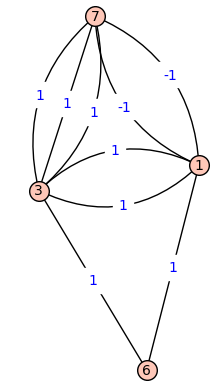

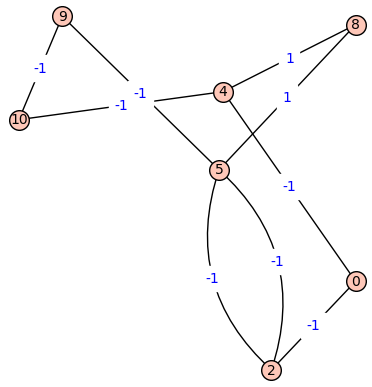

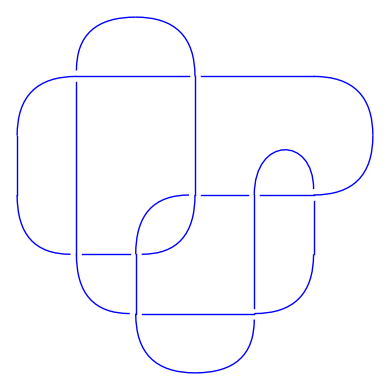

In [85]:
import sage.graphs.graph as graph
#testing grounds
L = snappy.Link('9_42')

black, white = test_white_graph(L)


def decorate_and_plot_graph(g):
    plot = g.plot(layout = 'spring', dist = 0.15, iterations = 20, edge_labels=True)
    plot.show()
    return g

decorate_and_plot_graph(white)
decorate_and_plot_graph(black)

L.sage_link().plot().show()

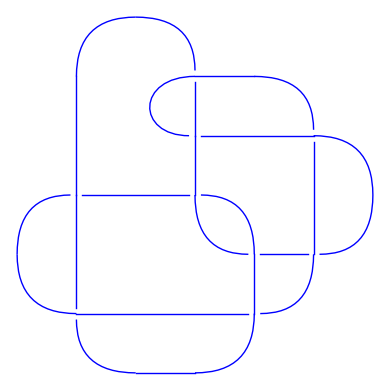

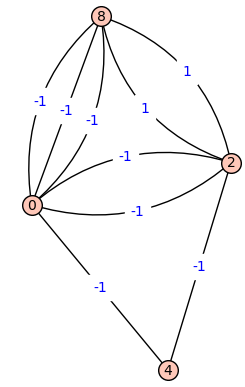

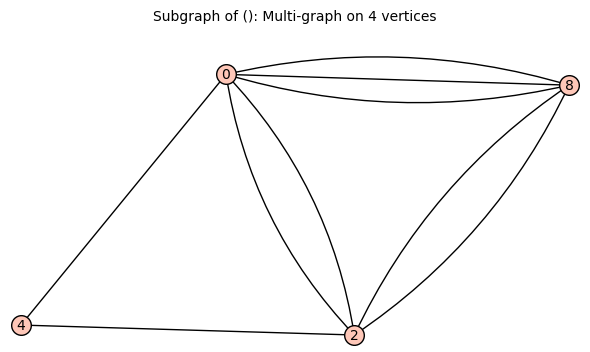

In [89]:
L9_42 = snappy.Link([(1,6,2,7),(7,2,8,3),(3,8,4,9),(4,12,5,11),(12,6,13,5),(13,1,14,18),(15,10,16,11),(9,16,10,17),(17,15,18,14)])
L9_42.sage_link().plot().show()
black, white = test_white_graph(L9_42)
decorate_and_plot_graph(white)